In [1]:
from typing import *
import numpy as np
from skimage import io
from skimage.transform import rescale, resize
import os
import matplotlib.pyplot as plt
from utils.common_functions import *
import cv2
from scipy import ndimage
from pyefd import elliptic_fourier_descriptors, reconstruct_contour, plot_efd, normalize_efd



### Reading images

In [2]:
def read_images():
    dataset_path = '../dataset'

    images = []
    labels = []
    for dirpath, _, filenames in os.walk(dataset_path):
        if not filenames: continue
        print(f'Processing directory {dirpath}...')
        for file in filenames:
            if not file.endswith('.jpg') and not file.endswith('.JPG'): 
                print(f'File {file} is not a jpg file. Skipping...')
                continue

            file_path = os.path.join(dirpath, file)

            # to avoid reading corrupted images
            image = cv2.imread(file_path)
            if image is None:
                print(f'File {file} is not a valid image. Skipping...')
                continue
            
            images.append(image)
            labels.append(int(file[0]))
    
    return images, labels

In [3]:
images, labels = read_images()


Processing directory ../dataset\men\0...
File desktop.ini is not a jpg file. Skipping...
Processing directory ../dataset\men\1...
File desktop.ini is not a jpg file. Skipping...
Processing directory ../dataset\men\2...
File 2_men (107).JPG is not a valid image. Skipping...
File 2_men (108).JPG is not a valid image. Skipping...
File desktop.ini is not a jpg file. Skipping...
Processing directory ../dataset\men\3...
File 3_men (140).JPG is not a valid image. Skipping...
File 3_men (141).JPG is not a valid image. Skipping...


KeyboardInterrupt: 

In [ ]:
print(f'Number of images: {len(images)}')

Number of images: 59


### Preprocessing

In [161]:
def crop_image(image, threshold=30):
    left = image[:, :threshold]
    right = image[:, -threshold:]

    white_count_left = np.sum(left == 255)
    white_count_right = np.sum(right == 255)
    
    if white_count_left > white_count_right:
        image = image[:, threshold:]
    else:
        image = image[:, :-threshold]
    return image

In [20]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    resize_ratio = 0.1


    image = cv2.resize(image, (int(image.shape[1] * resize_ratio), int(image.shape[0] * resize_ratio)))

    show_images([image], ['resized image'])
    show_images([image[:, :, 0], image[:, :, 1], image[:, :, 2]], ['Y', 'CR', 'CB'])

    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    show_images([image], ['YCRCB image'])

    # image[:, :, 0] = cv2.equalizeHist(image[:, : ,0])
    # show_images([image[:, :, 0], image[:, :, 1], image[:, :, 2]], ['Y', 'CR', 'CB'])
    
    lower_bound = np.array([0, 136, 77])
    upper_bound = np.array([255, 173, 127])
    image = cv2.inRange(image, lower_bound, upper_bound)
    show_images([image], ['Binary image'])

    kernel = np.ones((5, 5), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    show_images([image], ['Eroded image'])

    kernel = np.ones((5, 5), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    show_images([image], ['Eroded image'])

    image = ndimage.binary_fill_holes(image).astype(np.int8)
    image = change_gray_range(image, format=255)
    show_images([image], ['Holes filled image'])

    # print(image.shape)
    # image = crop_image(image)
    # show_images([image], ['Cropped image'])
    # print(image.shape)


    return image

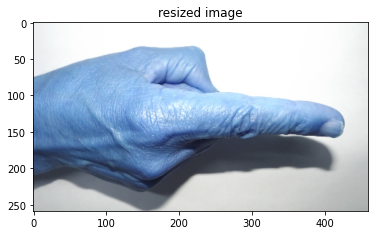

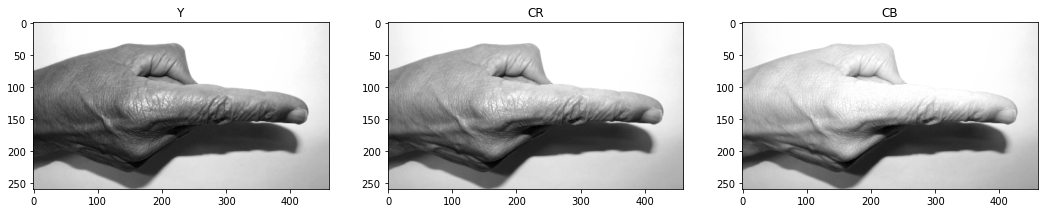

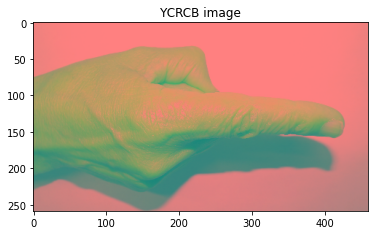

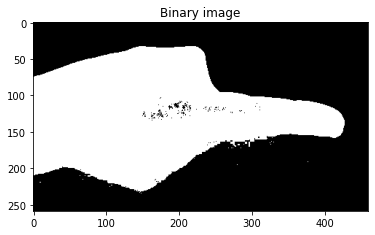

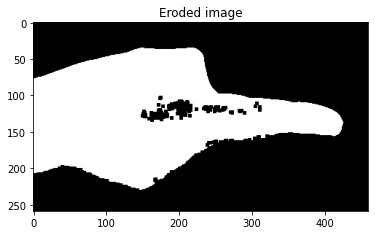

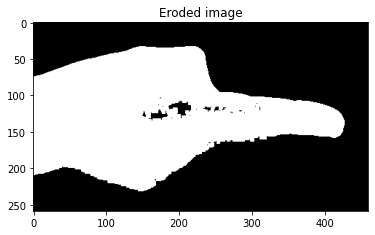

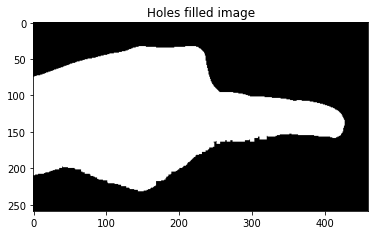

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
preprocess_image(cv2.imread('../dataset/men/1/1_men (58).JPG'))

In [147]:
# preprocess all images
for i in range(len(images)):
    images[i] = preprocess_image(images[i].copy())
    # break

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3940: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'


In [ ]:
# should return features
def elliptical_fourier(image: np.ndarray):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    threshold = 255 // 2
    image[image > threshold] = 255
    image[image <= threshold] = 0
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Draw all contours
    contours_image = np.zeros((image.shape[0], image.shape[1], 3))
    cv2.drawContours(contours_image, contours, -1, (0, 255, 255), 1)
    contours_image = contours_image.astype(np.uint8)
    show_images([contours_image], ['contours image'])

    # Draw largest contour
    max_contour = max(contours, key = cv2.contourArea)
    contours_image = np.zeros((image.shape[0], image.shape[1], 3))
    cv2.drawContours(contours_image, max_contour, -1, (0, 255, 255), 1)
    contours_image = contours_image.astype(np.uint8)
    show_images([contours_image], ['Largest contour image'])
    
    # Convert to 2d array
    max_contour = max_contour.reshape(max_contour.shape[0], max_contour.shape[2])
    coefficients = elliptic_fourier_descriptors(max_contour, order=50, normalize=False)

    contour = reconstruct_contour(coefficients)
    contour = contour.reshape(contour.shape[0], 1, contour.shape[1])
    contour = contour.astype(int)

    # min_values = np.min(contour, axis=0)
    # contour = contour - min_values

    contour[:, 0, 0] -= contour[:, 0, 0].min()
    contour[:, 0, 1] += contour[:, 0, 1].max()

    
    contours_image = np.zeros((image.shape[0], image.shape[1], 3))
    cv2.drawContours(contours_image, [contour], -1, (0, 255, 255), 1)
    contours_image = contours_image.astype(np.uint8)
    show_images([contours_image], ['Largest contour image'])

    coefficients = normalize_efd(coefficients)
    return coefficients.flatten()[3:]


In [ ]:
image = cv2.imread('../pp_dataset/3_19.JPG')
elliptical_fourier(image)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
